In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm

In [9]:
subject_id_default = 13620
dataloader = utils.MRIDataLoader()
TE_times = dataloader.get_TE_times()
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
info_dict = dataloader.get_info_dict()
thresh_default = 0.9
subject_ids = dataloader.get_subject_ids()
is_pre_term = dataloader.get_info(1) < 26
pre_term_ids = np.arange(subject_ids.shape[0])[is_pre_term]
full_term_ids = np.arange(subject_ids.shape[0])[~is_pre_term]
root_path = 'data/arrays/'

### Get estimate on T2 for WM, GM, CSF using Bootstrap on only Full Term subjects

nb_sample = 100
nb_bootstrap



In [89]:
roi_data_full, roi_seg_full = dataloader.load_all_roi_thresh_mono_data(thresh_default, subject_names='fullterm')

No File exists - Creating Data...


100%|##########| 50/50 [03:45<00:00,  4.50s/it]


In [91]:
nb_sample = 100
nb_bootstrap = 300

rois = ['WM', 'GM', 'CSF']
roi_bounds =   {'WM':   [(2000, 15000), (20, 120),  (20,2000)],
                'GM':   [(2000, 15000), (20, 120),  (20,2000)],
                'CSF':  [(2000, 15000), (50, 2000), (20,2000)]}
roi_T2_2 = {}
rmse_2 = {}
x0 = np.array([5000, 50, 60])
for roi in rois:
    print(f'Calculating {roi}...')
    roi_T2_2[roi] = []
    rmse_2[roi] = []
    roi_id = roi_dict[roi]
    nb_roi = roi_data_full[roi_id].shape[0]
    for bootstrap_id in tqdm(range(nb_bootstrap), ascii=True):
        sample_ids = np.random.randint(low=0, high=nb_roi, size=nb_sample)
        data = roi_data_full[roi_id][sample_ids,:]
        seg = roi_seg_full[roi_id][sample_ids,:]
        
        X0 = np.tile(x0, reps=nb_sample).reshape(nb_sample, -1)
        args_TE = np.tile(TE_times, reps=nb_sample).reshape(nb_sample, -1)
        
        v0 = seg[:,1:].max(axis=-1)
        v0 = np.where(v0 < 0.5, 0.5, v0)
        v = np.stack([v0, 1-v0], axis=-1)
        
        args = [data[:,1:], args_TE[:,1:], v]   # remove the first TE=13 signal
        bounds = roi_bounds[roi]
        
        problem_two_compartment = utils.create_problem_to_minimize('two_compartment', bounds=bounds)
        S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_print_progress=False)
        T2 = np.array([T2_0.mean(), T2_1.mean()])
        roi_T2_2[roi].append(T2)
        
        signal_est = utils.model_multi_compartment(np.stack([T2_0, T2_1], axis=-1), S0, TE_times, v)
        rmse = utils.RMSE(data, signal_est, dim=-1).sum() / nb_sample
        rmse_2[roi].append(rmse)
    roi_T2_2[roi] = np.stack(roi_T2_2[roi], axis=0)
    rmse_2[roi] = np.array(rmse_2[roi])

Calculating WM...


100%|##########| 300/300 [05:13<00:00,  1.05s/it]


Calculating GM...


100%|##########| 300/300 [06:21<00:00,  1.27s/it]


Calculating CSF...


100%|##########| 300/300 [05:22<00:00,  1.08s/it]


### Now do it on pre-term

In [92]:
roi_data_pre, roi_seg_pre = dataloader.load_all_roi_thresh_mono_data(thresh_default, subject_names='preterm')

No File exists - Creating Data...


100%|##########| 85/85 [04:26<00:00,  3.13s/it]


In [93]:
nb_sample = 100
nb_bootstrap = 300

rois = ['WM', 'GM', 'CSF']
roi_bounds = {'WM': [(2000, 15000), (20, 100), (20,2000)],
          'GM': [(2000, 15000), (20, 100), (20,2000)],
          'CSF': [(2000, 15000), (50, 2000), (20,2000)]}
roi_T2_2_pre = {}
rmse_2_pre = {}
x0 = np.array([5000, 50, 60])
for roi in rois:
    print(f'Calculating {roi}...')
    roi_T2_2_pre[roi] = []
    rmse_2_pre[roi] = []
    roi_id = roi_dict[roi]
    nb_roi = roi_data_pre[roi_id].shape[0]
    for bootstrap_id in tqdm(range(nb_bootstrap), ascii=True):
        sample_ids = np.random.randint(low=0, high=nb_roi, size=nb_sample)
        data = roi_data_pre[roi_id][sample_ids,:]
        seg = roi_seg_pre[roi_id][sample_ids,:]
        
        X0 = np.tile(x0, reps=nb_sample).reshape(nb_sample, -1)
        args_TE = np.tile(TE_times, reps=nb_sample).reshape(nb_sample, -1)
        
        v0 = seg[:,1:].max(axis=-1)
        v0 = np.where(v0 < 0.5, 0.5, v0)
        v = np.stack([v0, 1-v0], axis=-1)
        
        args = [data[:,1:], args_TE[:,1:], v]
        bounds = roi_bounds[roi]
        
        problem_two_compartment = utils.create_problem_to_minimize('two_compartment', bounds=bounds)
        S0, T2_0, T2_1 = utils.minimize_given_problem(problem=problem_two_compartment, X0=X0, args_list=args, is_print_progress=False)
        T2 = np.array([T2_0.mean(), T2_1.mean()])
        roi_T2_2_pre[roi].append(T2)
        
        signal_est = utils.model_multi_compartment(np.stack([T2_0, T2_1], axis=-1), S0, TE_times, v)
        rmse = utils.RMSE(data, signal_est, dim=-1).sum() / nb_sample
        rmse_2_pre[roi].append(rmse)
    roi_T2_2_pre[roi] = np.stack(roi_T2_2_pre[roi], axis=0)
    rmse_2_pre[roi] = np.array(rmse_2_pre[roi])

Calculating WM...


100%|##########| 300/300 [05:11<00:00,  1.04s/it]


Calculating GM...


100%|##########| 300/300 [06:36<00:00,  1.32s/it]


Calculating CSF...


100%|##########| 300/300 [05:52<00:00,  1.18s/it]


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_22104\598702102.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


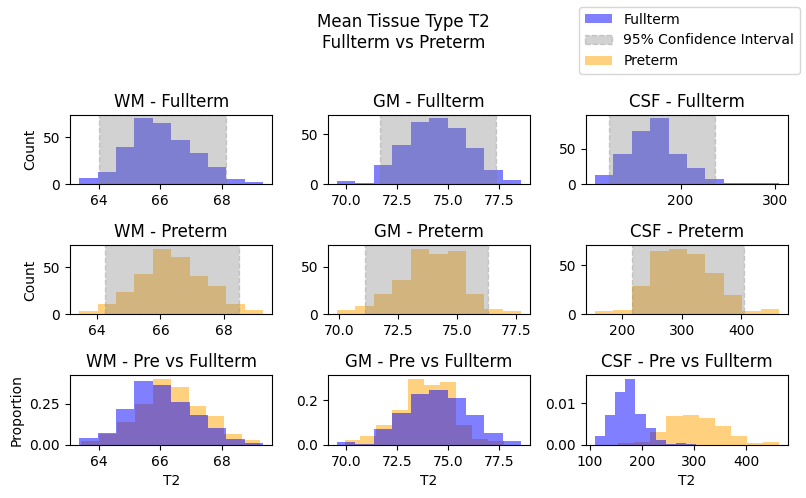

In [94]:
fig, axs = plt.subplots(3, len(rois), figsize=(8, 5))
col_interval = 'gray'
area_alpha = 0.35
col_pre = 'orange'
col_full = 'blue'
for col, roi in enumerate(rois):
    roi_id = roi_dict[roi]
    T2_full = roi_T2_2[roi]
    T2_pre = roi_T2_2_pre[roi]
    upper_lower_pre = np.percentile(T2_pre[:,0], [2.5, 97.5])
    upper_lower_full = np.percentile(T2_full[:,0], [2.5, 97.5])
    
    if col==0:
        axs[0, col].hist(T2_full[:,0], color=col_full, label='Fullterm', alpha=0.5)
        axs[0,col].set_title(f'{roi} - Fullterm')
        axs[0,col].set_ylabel(f'Count')
        
        axs[1, col].hist(T2_pre[:,0], color=col_pre, label='Preterm', alpha=0.5)
        axs[1,col].set_title(f'{roi} - Preterm')
        axs[1,col].set_ylabel(f'Count')
        
        axs[2,col].set_ylabel(f'Density')
        
        axs[0,col].axvspan(xmin=upper_lower_full[0], xmax=upper_lower_full[1], color=col_interval, alpha=area_alpha, linestyle='--', label='95% Confidence Interval')
        axs[1,col].axvspan(xmin=upper_lower_pre[0], xmax=upper_lower_pre[1], color=col_interval, alpha=area_alpha, linestyle='--', label='_95% Confidence Interval')
    else:
        axs[0, col].hist(T2_full[:,0], color=col_full, label='_Fullterm', alpha=0.5)
        axs[0,col].set_title(f'{roi} - Fullterm')
        
        axs[1, col].hist(T2_pre[:,0], color=col_pre, label='_Preterm', alpha=0.5)
        axs[1,col].set_title(f'{roi} - Preterm')
        
        axs[0,col].axvspan(xmin=upper_lower_full[0], xmax=upper_lower_full[1], color=col_interval, alpha=area_alpha, linestyle='--', label='_95% Confidence Interval')
        axs[1,col].axvspan(xmin=upper_lower_pre[0], xmax=upper_lower_pre[1], color=col_interval, alpha=area_alpha, linestyle='--', label='_95% Confidence Interval')
    
    axs[2,col].hist(T2_pre[:,0], color=col_pre, label='_Preterm', alpha=0.5, density=True)
    axs[2,col].hist(T2_full[:,0], color=col_full, label='_Fullterm', alpha=0.5, density=True)
    axs[2,col].set_title(f'{roi} - Pre vs Fullterm')

for col in range(len(rois)):
    axs[2, col].set_xlabel('T2')
    
fig.tight_layout()
fig.legend()
fig.suptitle('Mean Tissue Type T2\nFullterm vs Preterm\n')
fig.tight_layout()
fig.show()

In [101]:
print('Full Term')
for roi_id, roi in enumerate(rois):
    T2_full = roi_T2_2[roi][:,0]
    percentiles = np.percentile(T2_full, [2.5, 50, 97.5])
    print(f'{roi:<4}: median: {percentiles[1]:5.1f}, interval: ({percentiles[0]:5.1f}, {percentiles[2]:5.1f})')
    
print('\nPre Term')
for roi_id, roi in enumerate(rois):
    T2_pre = roi_T2_2_pre[roi][:,0]
    percentiles = np.percentile(T2_pre, [2.5, 50, 97.5])
    print(f'{roi:<4}: median: {percentiles[1]:5.1f}, interval: ({percentiles[0]:5.1f}, {percentiles[2]:5.1f})')

Full Term
WM  : median:  65.9, interval: ( 64.0,  68.2)
GM  : median:  74.5, interval: ( 71.7,  77.4)
CSF : median: 170.7, interval: (124.0, 236.5)

Pre Term
WM  : median:  66.3, interval: ( 64.3,  68.5)
GM  : median:  73.9, interval: ( 71.1,  76.3)
CSF : median: 303.1, interval: (217.0, 404.3)
